# Capstone Project

### Importing Packages
---

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import string
import re

from ast import literal_eval
from unidecode import unidecode

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

### Reading CSV Files
---

In [133]:
## Dataset of user ratings
## limited to first 5 million rows
ratings = pd.read_csv('archive\\ratings.csv').loc[0:5000001]
ratings.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [134]:
## Dataset of information on each film
films = pd.read_csv('archive\\movies_metadata.csv')
films.head()

C:\Users\Tom\AppData\Local\Temp\ipykernel_13860\2266583941.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  films = pd.read_csv('archive\\movies_metadata.csv')


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [135]:
films_copy = films.copy()

In [136]:
## Dataset linking ids between films and ratings datasets
links = pd.read_csv('archive\\links.csv')
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [137]:
## Dataset of keywords relating to films, linking to the films dataframe
keywords = pd.read_csv('archive\\keywords.csv')
keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


### Adjusting Data Types
---

In [138]:
films.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [139]:
films.dtypes

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                        object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object

In [140]:
### While trying to change data types, I identified three films that had been split across multiple columns
films[films['vote_count'].isnull()]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
19729,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,82663,tt0113002,en,Midnight Man,British soldiers force a recently captured IRA...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19730,- Written by Ørnås,0.065736,/ff9qCepilowshEtG2GYWwzt2bs4.jpg,"[{'name': 'Carousel Productions', 'id': 11176}...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",1997-08-20,0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29502,False,"{'id': 122661, 'name': 'Mardock Scramble Colle...",0,"[{'id': 16, 'name': 'Animation'}, {'id': 878, ...",http://m-scramble.jp/exhaust/,122662,tt2423504,ja,マルドゥック・スクランブル 排気,Third film of the Mardock Scramble series.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29503,Rune Balot goes to a casino connected to the ...,1.931659,/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg,"[{'name': 'Aniplex', 'id': 2883}, {'name': 'Go...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-09-29,0,68.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,...,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35586,False,NaN,0,"[{'id': 10770, 'name': 'TV Movie'}, {'id': 28,...",NaN,249260,tt2622826,en,Avalanche Sharks,A group of skiers are terrorized during spring...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35587,Avalanche Sharks tells the story of a bikini ...,2.185485,/zaSf5OG7V8X8gqFvly88zDdRm46.jpg,"[{'name': 'Odyssey Media', 'id': 17161}, {'nam...","[{'iso_3166_1': 'CA', 'name': 'Canada'}]",2014-01-01,0,82.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [141]:
### These films have few user votes each, so I can simply remove them from the data
films.dropna(subset = ['vote_count', 'release_date'], inplace = True)

In [142]:
### Dropping duplicate rows
films = films.drop_duplicates(subset=['id'])
keywords = keywords.drop_duplicates(subset=['id'])

In [143]:
## converting numerical values to integer/float
films['budget'] = films['budget'].astype(int)
films['id'] = films['id'].astype(int)
films['popularity'] = films['popularity'].astype(float)
films['revenue'] = films['revenue'].astype(int)
films['vote_average'] = films['vote_average'].astype(float)
films['vote_count'] = films['vote_count'].astype(int)

In [144]:
## Films with no runtime do not seem notable enough to keep in the data
films[films['runtime'].isnull()].sort_values('vote_count', ascending=False).head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
43596,False,NaN,0,"[{'id': 35, 'name': 'Comedy'}]",NaN,439998,tt6373590,it,Omicidio all'italiana,NaN,...,2017-03-02,0,NaN,"[{'iso_639_1': 'it', 'name': 'Italiano'}]",In Production,NaN,Omicidio all'italiana,False,6.3,69
35491,False,NaN,0,"[{'id': 35, 'name': 'Comedy'}]",NaN,298722,tt3358470,it,Soap Opera,NaN,...,2014-10-23,0,NaN,[],Released,NaN,Soap Opera,False,5.3,46
31556,False,NaN,0,"[{'id': 35, 'name': 'Comedy'}]",NaN,270479,tt3761504,it,Ammutta muddica al cinema,NaN,...,2013-10-16,0,NaN,[],Released,NaN,Ammutta muddica al cinema,False,6.3,43
41922,False,NaN,0,"[{'id': 35, 'name': 'Comedy'}]",NaN,392832,tt5662556,it,Nemiche per la pelle,NaN,...,2016-04-14,0,NaN,"[{'iso_639_1': 'it', 'name': 'Italiano'}]",Released,NaN,Nemiche per la pelle,False,5.7,31
30782,False,NaN,0,"[{'id': 35, 'name': 'Comedy'}]",NaN,60046,tt0054442,it,Il vigile,NaN,...,1960-01-01,0,NaN,"[{'iso_639_1': 'it', 'name': 'Italiano'}]",Released,NaN,Il vigile,False,7.8,29


In [145]:
## drop null values and convert to integer
films.dropna(subset=['runtime'], inplace = True)
films['runtime'] = films['runtime'].astype(int)

In [146]:
## extracting year from release date and converting to integer
films['year'] = films['release_date'].str[0:4].astype(int)

In [147]:
films.dtypes

adult                     object
belongs_to_collection     object
budget                     int32
genres                    object
homepage                  object
id                         int32
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity               float64
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                    int32
runtime                    int32
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count                 int32
year                       int32
dtype: object

In [148]:
links.dtypes

movieId      int64
imdbId       int64
tmdbId     float64
dtype: object

In [149]:
ratings.dtypes

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

### Visualising Data
---

In [150]:
films.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,373554033,81,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415,1995
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,262797249,104,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413,1995
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,0,101,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92,1995
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,81452156,127,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34,1995
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,76578911,106,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173,1995


In [151]:
films['adult'].value_counts()

### I should remove the 8 adult films from the data.

False    45092
True         8
Name: adult, dtype: int64

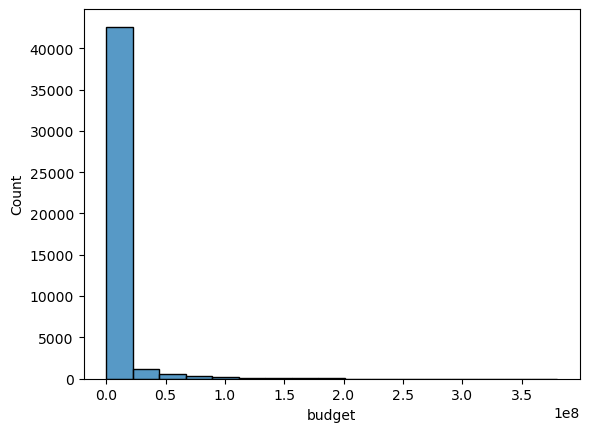

In [152]:
sns.histplot(films['budget'])
plt.show()

## histogram of budgets column

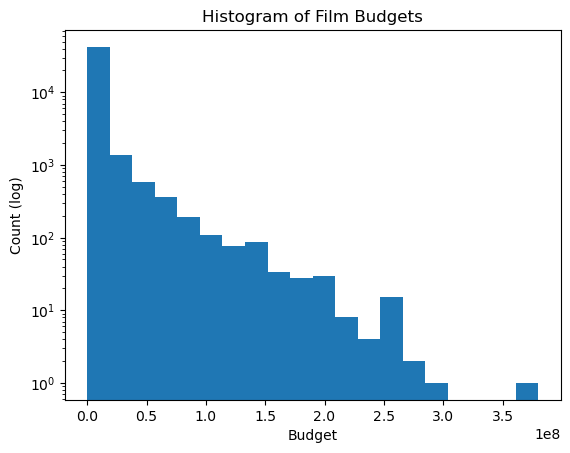

In [153]:
## Histogram of Budgets using a log scale
plt.hist(data=films, x='budget', bins=20, log=True)
plt.title('Histogram of Film Budgets')
plt.xlabel('Budget')
plt.ylabel('Count (log)')
plt.show()

In [154]:
len(films[films['budget']==0])/len(films)

## 80% of the films in the data do not have a specified budget

0.8034146341463415

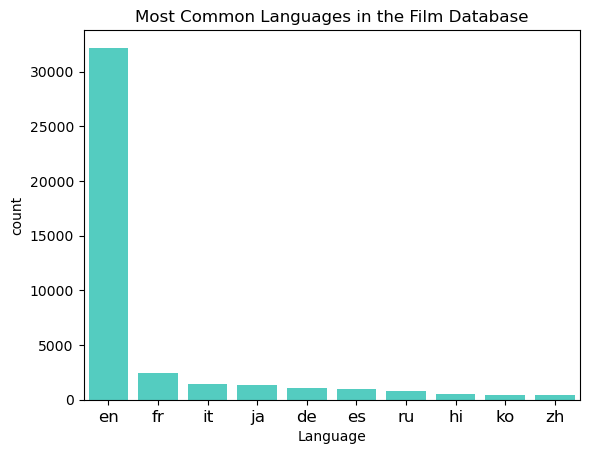

In [155]:
sns.countplot(x='original_language',
              data=films,
              color='turquoise',
              order = films['original_language'].value_counts()[0:10].index)

plt.xticks(fontsize ='large')
plt.title('Most Common Languages in the Film Database')
plt.xlabel('Language')
plt.show()

In [156]:
films.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,373554033,81,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415,1995
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,262797249,104,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413,1995
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,0,101,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92,1995
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,81452156,127,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34,1995
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,76578911,106,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173,1995


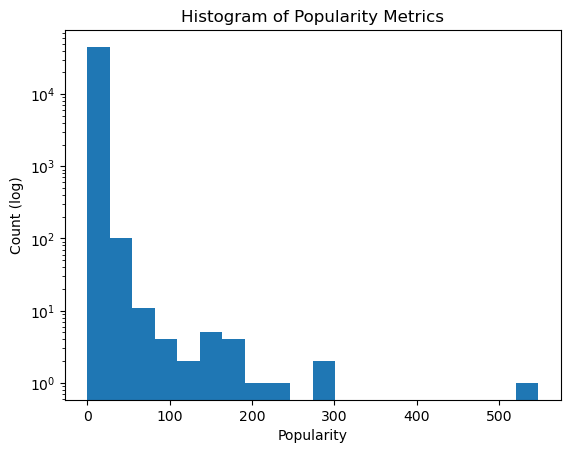

In [157]:
plt.hist(data=films, x='popularity', bins=20, log=True)
plt.title('Histogram of Popularity Metrics')
plt.xlabel('Popularity')
plt.ylabel('Count (log)')
plt.show()

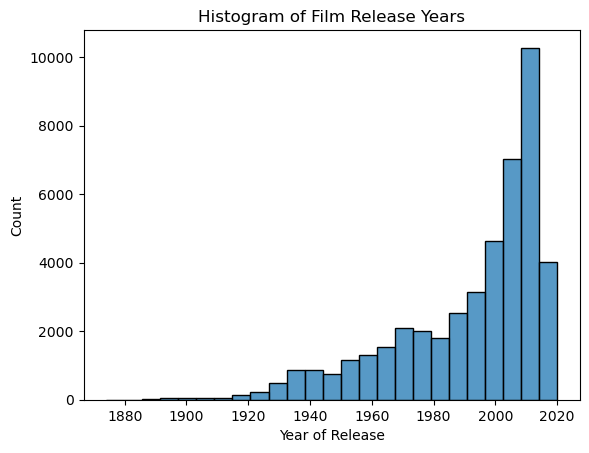

In [158]:
sns.histplot(films['year'], bins=25)
plt.title('Histogram of Film Release Years')
plt.xlabel('Year of Release')

plt.savefig('years_films.png', dpi = 300, bbox_inches = 'tight', transparent=True)
plt.show()

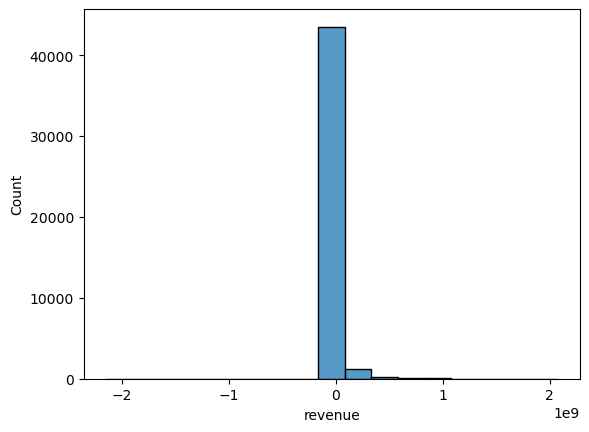

In [159]:
sns.histplot(films['revenue'])
plt.show()

In [160]:
len(films[films['revenue']==0])/len(films)

## Revenue column is empty for most films
## I will drop this column entirely

0.8361197339246119

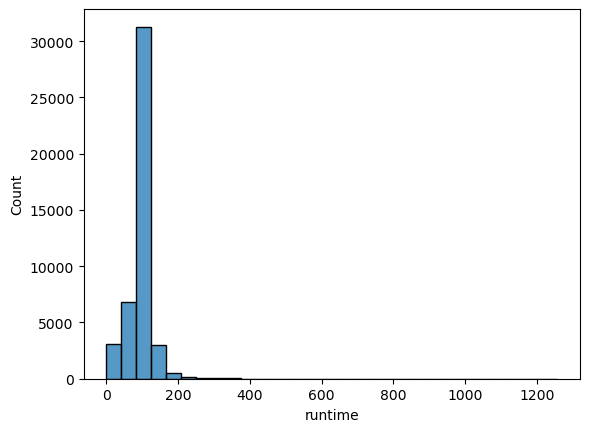

In [161]:
sns.histplot(films['runtime'], bins=30)
plt.show()

## There will be some extreme outliers for runtime
## I can consider removing these

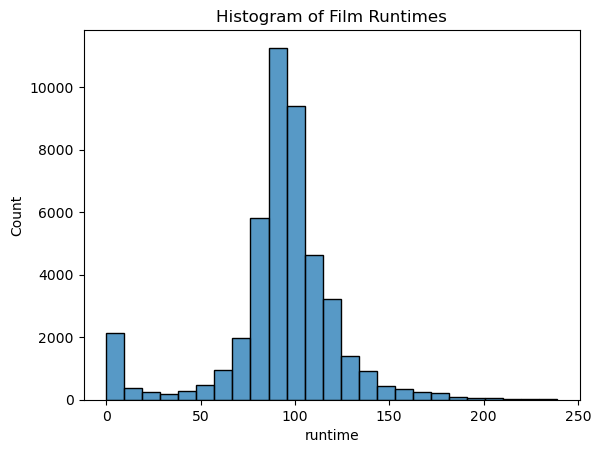

In [162]:
sns.histplot(films[films['runtime']<240]['runtime'], bins=25)
plt.title('Histogram of Film Runtimes')
plt.show()

In [163]:
films['status'].value_counts()

## I want to limit my data to released films only

Released           44667
Rumored              229
Post Production       97
In Production         17
Planned               13
Canceled               1
Name: status, dtype: int64

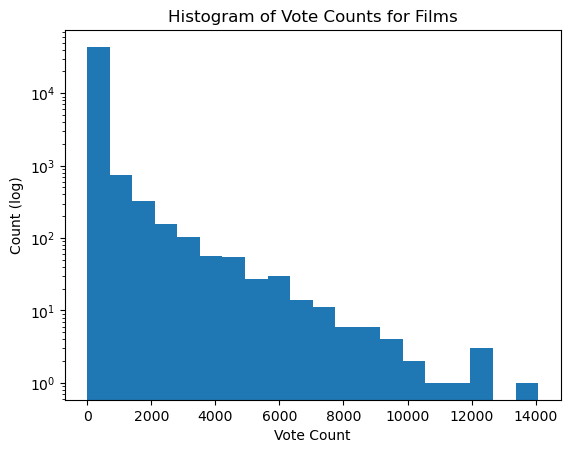

In [164]:
plt.hist(data=films, x='vote_count', bins=20, log=True)
plt.title('Histogram of Vote Counts for Films')
plt.xlabel('Vote Count')
plt.ylabel('Count (log)')
plt.show()


In [165]:
films['video'].value_counts()

False    45012
True        88
Name: video, dtype: int64

In [166]:
## I can drop any rows where Video = True

films[films['video']==True].sort_values('vote_count')

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year
36523,False,NaN,0,"[{'id': 12, 'name': 'Adventure'}, {'id': 99, '...",http://www.senderfilms.com/firstascentseries.com/,52236,tt1735363,en,First Ascent: The Series,First Ascent is Sender Films' groundbreaking 6...,...,0,0,[],Released,NaN,First Ascent: The Series,True,0.0,0,2010
33383,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,307276,tt1172162,el,2,On 24 November 2006 Papaioannou premiered 2 in...,...,0,96,"[{'iso_639_1': 'el', 'name': 'ελληνικά'}]",Released,NaN,2,True,0.0,0,2007
40141,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 99, 'nam...",NaN,247488,tt0471614,en,"Cheating Death, Stealing Life: The Eddie Guerr...",Born into Mexico's first family of sports-ente...,...,0,44,[],Released,NaN,"Cheating Death, Stealing Life: The Eddie Guerr...",True,0.0,0,2004
34269,False,NaN,0,"[{'id': 36, 'name': 'History'}, {'id': 18, 'na...",NaN,315226,tt4219894,en,Lokmanya: Ek Yug Purush,The film encompasses some of a lifetime span o...,...,0,139,"[{'iso_639_1': 'mr', 'name': ''}, {'iso_639_1'...",Released,“Father of Indian Unrest” (Bal Gangadhar Tilak),Lokmanya: Ek Yug Purush,True,0.0,0,2015
44981,False,NaN,0,"[{'id': 10751, 'name': 'Family'}, {'id': 18, '...",NaN,461088,tt5689610,fa,۵۰ کیلو آلبالو,When the corrupted groom starts shooting in th...,...,0,89,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,NaN,50 Kilos of Sour Cherry,True,0.0,0,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43224,False,NaN,0,"[{'id': 10770, 'name': 'TV Movie'}, {'id': 53,...",NaN,284457,tt5334704,en,Twin Peaks: Fire Walk with Me - The Missing Pi...,The long-awaited missing pieces from the origi...,...,0,91,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Twin Peaks: Fire Walk with Me - The Missing Pi...,True,7.5,34,2014
44286,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 16, 'nam...",NaN,161337,tt2381375,en,Underworld: Endless War,Underworld: Endless War is a collection of thr...,...,0,18,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Underworld: Endless War,True,5.6,38,2011
30904,False,"{'id': 141748, 'name': 'Robot Chicken: Star Wa...",0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",NaN,42979,tt1020990,en,Robot Chicken: Star Wars,"Fans of Adult Swim's ""Robot Chicken"" and the S...",...,0,23,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Spend Father's Day with who really raised you....,Robot Chicken: Star Wars,True,6.9,58,2007
15454,False,NaN,0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",NaN,16023,tt1308667,en,South Park: Imaginationland,Some of the boys in South Park elementary find...,...,0,67,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,South Park: Imaginationland,True,7.9,75,2008


In [167]:
films[films['original_language'].isnull()].sort_values('vote_count')

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year
19574,False,NaN,0,"[{'id': 99, 'name': 'Documentary'}]",NaN,283101,tt0429086,NaN,Shadowing the Third Man,Documentary about the production of The Third ...,...,0,95,"[{'iso_639_1': 'de', 'name': 'Deutsch'}, {'iso...",Released,NaN,Shadowing the Third Man,False,0.0,0,2004
22832,False,NaN,0,"[{'id': 10752, 'name': 'War'}, {'id': 37, 'nam...",NaN,359195,tt0053558,NaN,13 Fighting Men,A group of Union Army soldiers is charged with...,...,0,69,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,13 Fighting Men,False,0.0,0,1960
44057,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,380438,tt0298411,NaN,Lettre d'une inconnue,NaN,...,0,0,"[{'iso_639_1': 'fr', 'name': 'Français'}]",Released,NaN,Lettre d'une inconnue,False,0.0,0,2001
44410,False,NaN,0,"[{'id': 16, 'name': 'Animation'}, {'id': 99, '...",NaN,381096,tt5333518,NaN,Garn,The traditional crafts of crochet and knitting...,...,0,76,"[{'iso_639_1': 'sv', 'name': 'svenska'}, {'iso...",Released,NaN,Yarn,False,0.0,0,2016
44576,False,NaN,0,[],NaN,381525,tt5376720,NaN,WiNWiN,American investment fund buys Austrian compani...,...,0,84,"[{'iso_639_1': 'de', 'name': 'Deutsch'}, {'iso...",Released,NaN,WiNWiN,False,0.0,0,2016
37407,False,NaN,0,"[{'id': 16, 'name': 'Animation'}]",NaN,257095,tt0225145,NaN,Bajaja,The first fairy tale transformed into a full-l...,...,0,87,"[{'iso_639_1': 'cs', 'name': 'Český'}]",Released,NaN,Prince Bayaya,False,5.0,1,1950
32141,False,NaN,0,"[{'id': 35, 'name': 'Comedy'}]",NaN,147050,tt0122580,NaN,Lambchops,George and Gracie enter an elegant drawing roo...,...,0,8,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Lambchops,False,6.5,2,1929
41047,False,NaN,0,"[{'id': 99, 'name': 'Documentary'}]",NaN,332742,tt4432912,NaN,Song of Lahore,"Until the late 1970s, the Pakistani city of La...",...,0,82,"[{'iso_639_1': 'ur', 'name': 'اردو'}, {'iso_63...",Released,NaN,Song of Lahore,False,6.5,2,2015
44655,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 10752, '...",NaN,104473,tt0223958,NaN,La prise de Tournavos,"Three military men, seen inside a fortificatio...",...,0,1,"[{'iso_639_1': 'xx', 'name': 'No Language'}]",Rumored,NaN,The Surrender of Tournavos,False,4.6,5,1897
21602,False,NaN,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 18, ...",NaN,103902,tt0838231,NaN,Unfinished Sky,An Outback farmer takes in an Afghani woman wh...,...,0,94,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Unfinished Sky,False,6.4,8,2007


In [168]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


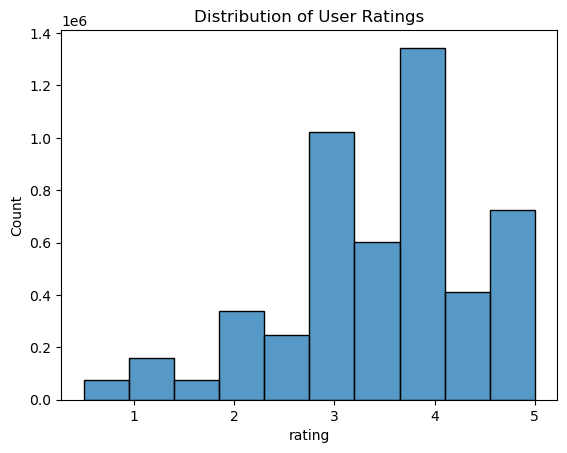

In [169]:
sns.histplot(ratings['rating'], bins=10)
plt.title('Distribution of User Ratings')
plt.show()

### Data Cleaning
---

In [170]:
films.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45100 entries, 0 to 45465
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45100 non-null  object 
 1   belongs_to_collection  4478 non-null   object 
 2   budget                 45100 non-null  int32  
 3   genres                 45100 non-null  object 
 4   homepage               7761 non-null   object 
 5   id                     45100 non-null  int32  
 6   imdb_id                45088 non-null  object 
 7   original_language      45089 non-null  object 
 8   original_title         45100 non-null  object 
 9   overview               44405 non-null  object 
 10  popularity             45100 non-null  float64
 11  poster_path            44778 non-null  object 
 12  production_companies   45100 non-null  object 
 13  production_countries   45100 non-null  object 
 14  release_date           45100 non-null  object 
 15  re

In [171]:
## Remove adult films
films = films[films['adult']=='False']
## Remove films that have not been released
films = films[films['status']=='Released']
## Remove Direct-to-Video films
films = films[films['video']==False]

In [172]:
## Drop nulls from original language column
films.dropna(subset='original_language', inplace=True)

In [173]:
films['tmdbId'] = films['id']

In [174]:
## I will use the Vote Count and Vote Average Columns to calculate a weighted rating.
## I can do this using the formula used by IMDB.

C = ratings['rating'].mean()
m = 20

def adjust_rating(vote_mean, vote_count):
    """A formula to calculate the weighted rating of a film.
    Input: Mean rating and total number of votes
    Output: Weighted rating using IMDB's formula
    """
    if vote_count > 0:
        new_rating = (vote_mean*vote_count/(vote_count+m))+(C*m/(vote_count+m))
    else:
        ### If there are no ratings, give output as zero
        new_rating = 0
    return new_rating

In [175]:
films['adj_rating'] = films.apply(lambda x: adjust_rating(x['vote_average'],x['vote_count']), axis=1)

In [176]:
films = films[['tmdbId','title','year','genres','original_language','original_title','overview','popularity','poster_path','production_companies','production_countries','runtime','spoken_languages','tagline','vote_average','vote_count','adj_rating']]

In [177]:
films.head()

,tmdbId,title,year,genres,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,runtime,spoken_languages,tagline,vote_average,vote_count,adj_rating
0,862,Toy Story,1995,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",81,"[{'iso_639_1': 'en', 'name': 'English'}]",NaN,7.7,5415,7.684640
1,8844,Jumanji,1995,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",104,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Roll the dice and unleash the excitement!,6.9,2413,6.872264
2,15602,Grumpier Old Men,1995,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",101,"[{'iso_639_1': 'en', 'name': 'English'}]",Still Yelling. Still Fighting. Still Ready for...,6.5,92,5.968905
3,31357,Waiting to Exhale,1995,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",127,"[{'iso_639_1': 'en', 'name': 'English'}]",Friends are the people who let you be yourself...,6.1,34,5.146619
4,11862,Father of the Bride Part II,1995,"[{'id': 35, 'name': 'Comedy'}]",en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",106,"[{'iso_639_1': 'en', 'name': 'English'}]",Just When His World Is Back To Normal... He's ...,5.7,173,5.474702


In [178]:
films.sort_values('adj_rating',ascending=False)

,tmdbId,title,year,genres,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,runtime,spoken_languages,tagline,vote_average,vote_count,adj_rating
10309,19404,Dilwale Dulhania Le Jayenge,1995,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",hi,Dilwale Dulhania Le Jayenge,"Raj is a rich, carefree, happy-go-lucky second...",34.457024,/2gvbZMtV1Zsl7FedJa5ysbpBx2G.jpg,"[{'name': 'Yash Raj Films', 'id': 1569}]","[{'iso_3166_1': 'IN', 'name': 'India'}]",190,"[{'iso_639_1': 'hi', 'name': 'हिन्दी'}]",Come... Fall In Love,9.1,661,8.936296
314,278,The Shawshank Redemption,1994,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",en,The Shawshank Redemption,Framed in the 1940s for the double murder of h...,51.645403,/9O7gLzmreU0nGkIB6K3BsJbzvNv.jpg,"[{'name': 'Castle Rock Entertainment', 'id': 9...","[{'iso_3166_1': 'US', 'name': 'United States o...",142,"[{'iso_639_1': 'en', 'name': 'English'}]",Fear can hold you prisoner. Hope can set you f...,8.5,8358,8.488126
834,238,The Godfather,1972,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",en,The Godfather,"Spanning the years 1945 to 1955, a chronicle o...",41.109264,/rPdtLWNsZmAtoZl9PK7S2wE3qiS.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",175,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",An offer you can't refuse.,8.5,6024,8.483540
40251,372058,Your Name.,2016,"[{'id': 10749, 'name': 'Romance'}, {'id': 16, ...",ja,君の名は。,High schoolers Mitsuha and Taki are complete s...,34.461252,/xq1Ugd62d23K2knRUx6xxuALTZB.jpg,"[{'name': 'CoMix Wave Films', 'id': 10198}]","[{'iso_3166_1': 'JP', 'name': 'Japan'}]",106,"[{'iso_639_1': 'ja', 'name': '日本語'}]",NaN,8.5,1030,8.405255
12481,155,The Dark Knight,2008,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",en,The Dark Knight,Batman raises the stakes in his war on crime. ...,123.167259,/1hRoyzDtpgMU7Dz4JF22RANzQO7.jpg,"[{'name': 'DC Comics', 'id': 429}, {'name': 'L...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",152,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Why So Serious?,8.3,12269,8.292230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34599,183964,Facciamo paradiso,1995,[],it,Facciamo paradiso,NaN,0.002368,/wFqV6t0ccTWPMmn5PouHRuGnwM1.jpg,[],[],0,[],NaN,0.0,0,0.000000
34596,67177,Dear Michele,1976,[],it,Caro Michele,NaN,0.003794,/v1OzHfZMff1KXcCXkJpz2nKtAwt.jpg,[],[],0,"[{'iso_639_1': 'it', 'name': 'Italiano'}]",NaN,0.0,0,0.000000
34570,61208,Ferdinando and Carolina,1999,[],it,Ferdinando e Carolina,"On his death bed in the 1820s, King Ferdinando...",0.010305,/tgXdRBMn5qarLP18Ovke6yqqAQH.jpg,[],[],102,[],NaN,0.0,0,0.000000
34567,293189,Algorithms,2013,"[{'id': 99, 'name': 'Documentary'}]",en,Algorithms,Four blind Indian boys compete to become chess...,0.011525,/4SRoDXWY6XGfI4qthDpsECwAySC.jpg,"[{'name': 'AkamPuram', 'id': 33271}]","[{'iso_3166_1': 'IN', 'name': 'India'}, {'iso_...",100,"[{'iso_639_1': 'en', 'name': 'English'}]",NaN,0.0,0,0.000000


In [179]:
films[films['overview'].isnull()].sort_values('vote_count', ascending=False).head()

## There are no particularly notable films without an overview in the data
## Overview will be extremely important when looking at similarity, so I should drop these rows.

,tmdbId,title,year,genres,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,runtime,spoken_languages,tagline,vote_average,vote_count,adj_rating
31600,35554,Cado dalle nubi,2009,"[{'id': 35, 'name': 'Comedy'}]",it,Cado dalle nubi,NaN,6.404770,/4hUvmgjtr6VP9DpXMe8gaTS5qki.jpg,"[{'name': 'Apulia Film Commission', 'id': 1203...","[{'iso_3166_1': 'IT', 'name': 'Italy'}]",99,"[{'iso_639_1': 'it', 'name': 'Italiano'}]",NaN,6.5,299,6.313534
28549,50531,Chiedimi se sono felice,2000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",it,Chiedimi se sono felice,NaN,4.288138,/42t4vCBM3Hplq5vCOhynSsZOuu2.jpg,[],"[{'iso_3166_1': 'IT', 'name': 'Italy'}]",0,"[{'iso_639_1': 'it', 'name': 'Italiano'}]",NaN,7.5,273,7.228728
31547,58013,The Santa Claus Gang,2010,"[{'id': 35, 'name': 'Comedy'}]",it,La Banda Dei Babbi Natale,NaN,3.670624,/oVwDjF4Cpb0y6MWPysZcv4XzNjg.jpg,"[{'name': 'Medusa Film', 'id': 6246}, {'name':...","[{'iso_3166_1': 'IT', 'name': 'Italy'}]",100,"[{'iso_639_1': 'it', 'name': 'Italiano'}]",NaN,5.8,185,5.578134
31583,57112,Tu la conosci Claudia?,2004,"[{'id': 35, 'name': 'Comedy'}]",it,Tu la conosci Claudia?,NaN,5.038131,/ks7s6HUvHud2Ik4fOJSCDlW4pMc.jpg,"[{'name': 'Medusa Film', 'id': 6246}, {'name':...","[{'iso_3166_1': 'IT', 'name': 'Italy'}]",0,"[{'iso_639_1': 'it', 'name': 'Italiano'}]",NaN,6.6,183,6.297130
34178,310126,"Il ricco, il povero e il maggiordomo",2014,"[{'id': 35, 'name': 'Comedy'}]",it,"Il ricco, il povero e il maggiordomo",NaN,4.213349,/fRrPJX8oUFKDAq0gtaa6H27mMjb.jpg,[],"[{'iso_3166_1': 'IT', 'name': 'Italy'}]",0,[],NaN,5.6,178,5.390492


In [180]:
films[films['tagline'].isnull()].sort_values('vote_count', ascending=False).head()

## There are many significant films that do not have a tagline

,tmdbId,title,year,genres,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,runtime,spoken_languages,tagline,vote_average,vote_count,adj_rating
13724,14160,Up,2009,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",en,Up,Carl Fredricksen spent his entire life dreamin...,19.330884,/nk11pvocdb5zbFhX5oq5YiLPYMo.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",96,"[{'iso_639_1': 'en', 'name': 'English'}]",NaN,7.8,7048,7.787906
0,862,Toy Story,1995,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",81,"[{'iso_639_1': 'en', 'name': 'English'}]",NaN,7.7,5415,7.684640
20536,72559,G.I. Joe: Retaliation,2013,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",en,G.I. Joe: Retaliation,"Framed for crimes against the country, the G.I...",10.560608,/swk1AHwPvIJv8NUFM1qpFuaT642.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",110,"[{'iso_639_1': 'en', 'name': 'English'}]",NaN,5.4,3045,5.387771
31390,278927,The Jungle Book,2016,"[{'id': 10751, 'name': 'Family'}, {'id': 12, '...",en,The Jungle Book,After a threat from the tiger Shere Khan force...,17.432758,/vOipe2myi26UDwP978hsYOrnUWC.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",106,"[{'iso_639_1': 'en', 'name': 'English'}]",NaN,6.7,2977,6.678818
26560,166426,Pirates of the Caribbean: Dead Men Tell No Tales,2017,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",en,Pirates of the Caribbean: Dead Men Tell No Tales,"Thrust into an all-new paycheck, a down-on-his...",133.827820,/xbpSDU3p7YUGlu9Mr6Egg2Vweto.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",129,"[{'iso_639_1': 'en', 'name': 'English'}]",NaN,6.6,2814,6.578305


In [181]:
## Drop films that do not have an overview
films.dropna(subset='overview', inplace=True)
## For tagline, replace null values with an empty string
films['tagline'] = films['tagline'].fillna('')

In [182]:
## checking for outliers in film runtime
films[films['runtime']>240].sort_values('vote_count', ascending=False)

## a lot of these are TV shows, but there are also some films mixed in.
## However, I am not sure I want to recommend any films over four hours long anyway
## Hence, I am happy to remove these from the data

,tmdbId,title,year,genres,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,runtime,spoken_languages,tagline,vote_average,vote_count,adj_rating
43190,331214,Band of Brothers,2001,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",en,Band of Brothers,Drawn from interviews with survivors of Easy C...,7.903731,/yRXTVpDRBA3983C3HjoY0SO4dV6.jpg,"[{'name': 'HBO', 'id': 6068}]","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",705,"[{'iso_639_1': 'de', 'name': 'Deutsch'}, {'iso...",Ordinary men. Extraordinary times.,8.2,725,8.074520
27656,189197,The Pacific,2010,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",en,The Pacific,"A 10-part mini-series from the creators of ""Ba...",6.092242,/xV7FKNqOwnO3aJSiRM8WCrwdRS8.jpg,"[{'name': 'Playtone', 'id': 4171}, {'name': 'H...","[{'iso_3166_1': 'US', 'name': 'United States o...",540,"[{'iso_639_1': 'en', 'name': 'English'}]",Hell was an ocean away,7.9,318,7.641176
38244,347938,11.22.63,2016,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...",en,11.22.63,An English teacher travels back in time to pre...,5.791978,/5EJGeeuPy19EGDy8HErpbHba0yq.jpg,"[{'name': 'Warner Bros. Television', 'id': 195...","[{'iso_3166_1': 'US', 'name': 'United States o...",432,"[{'iso_639_1': 'en', 'name': 'English'}]","When you fight the past, the past fights back.",8.0,213,7.615955
39085,192040,Planet Earth,2006,"[{'id': 99, 'name': 'Documentary'}]",en,Planet Earth,A documentary miniseries described by its make...,4.501137,/zX2tjZXInTpKqFWI8Tf9LYeCg97.jpg,"[{'name': 'BBC', 'id': 5996}, {'name': 'Discov...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",550,"[{'iso_639_1': 'en', 'name': 'English'}]",planet earth as you've never seen it before,8.8,176,8.261823
9043,13519,The Stand,1994,"[{'id': 12, 'name': 'Adventure'}, {'id': 18, '...",en,The Stand,The human race is wiped out by a government in...,10.374919,/43GfSryOACjBeqbIL6VEwoxOU6t.jpg,"[{'name': 'Laurel Entertainment', 'id': 2483},...","[{'iso_3166_1': 'US', 'name': 'United States o...",366,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",The end of the world is just the beginning.,6.7,155,6.337242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40837,243984,Persuasion,1971,[],en,Persuasion,Adaptation of the Jane Austen novel.,0.001459,/aeJLz6OaQIRfr5roacf9WG3CTFd.jpg,[],[],300,"[{'iso_639_1': 'en', 'name': 'English'}]",,0.0,0,0.000000
19914,232005,Jude the Obscure,1971,"[{'id': 18, 'name': 'Drama'}]",en,Jude the Obscure,"Born into poverty, young Jude refuses to accep...",0.109213,/bwr6ZtU28BWHSwYOdyABmxGVGVt.jpg,[{'name': 'British Broadcasting Corporation (B...,"[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",300,[],,0.0,0,0.000000
18727,261035,Captain Midnight,1942,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",en,Captain Midnight,Secret Service Major Steel is one of the few m...,0.011161,/7XlBUnLo1De9KqlcAYU7gxzKEmh.jpg,[],[],270,"[{'iso_639_1': 'en', 'name': 'English'}]",,0.0,0,0.000000
26792,266314,Space,1985,"[{'id': 18, 'name': 'Drama'}, {'id': 10770, 'n...",en,Space,A 13-hour mini-series detailing James A. Michn...,0.632363,/mNkxKBlR3FYYRkmhdJo2OiqOGFs.jpg,[],[],600,[],,0.0,0,0.000000


In [183]:
films[films['runtime']<60].sort_values('vote_count',ascending=False)

,tmdbId,title,year,genres,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,runtime,spoken_languages,tagline,vote_average,vote_count,adj_rating
30061,251516,Kung Fury,2015,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",en,Kung Fury,"During an unfortunate series of events, a frie...",7.741143,/oJWzpGCLIj3uYa0ux19T2WwzTOf.jpg,"[{'name': 'Laser Unicorns', 'id': 19546}]","[{'iso_3166_1': 'SE', 'name': 'Sweden'}]",31,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",It takes a cop from the future to fight an ene...,7.6,762,7.495802
19901,140420,Paperman,2012,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",en,Paperman,An urban office worker finds that paper airpla...,7.198633,/3TpMBcAYH4cxCw5WoRacWodMTCG.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",7,"[{'iso_639_1': 'en', 'name': 'English'}]","Delicate, charming and sweet.",8.0,734,7.881323
28665,326359,Frozen Fever,2015,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",en,Frozen Fever,"On Anna's birthday, Elsa and Kristoff are dete...",9.509334,/lKJiVPzsAO9IJ4LKWXZ8vkR2bg4.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",8,"[{'iso_639_1': 'en', 'name': 'English'}]",,6.9,630,6.796181
39386,399106,Piper,2016,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",en,Piper,A mother bird tries to teach her little one ho...,11.243161,/jLRllZsubY8UWpeMyDLVXdRyEWi.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3},...","[{'iso_3166_1': 'US', 'name': 'United States o...",6,"[{'iso_639_1': 'en', 'name': 'English'}]",,8.2,487,8.015616
31658,293299,Feast,2014,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",en,Feast,This Oscar-winning animated short film tells t...,7.365663,/qJ9ouIj4wN24asvKTUSAcJnSfrT.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",6,"[{'iso_639_1': 'en', 'name': 'English'}]",Pet is not just a pet,8.0,420,7.796630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27510,44666,Surprise,1996,[],it,Surprise,"While his lover is sleeping, a man assembles a...",0.001252,/tfYsCJd9lsZjfS2LVqqHoxw1QqF.jpg,[],[],6,[],,0.0,0,0.000000
41896,432132,Sobriety,2016,"[{'id': 18, 'name': 'Drama'}]",en,Sobriety,"After a dark night, a man considers his option...",0.073829,/ktBNvAjJmeJSGMJRIFCnqCIuOeo.jpg,[],[],2,[],,0.0,0,0.000000
27484,281615,Santa's Pocket Watch,1980,[],en,Santa's Pocket Watch,"Sam dreams of meeting Father Christmas, so whe...",0.000263,/oupb2kmOmJmFDD8SWIztWpZ5TOq.jpg,[],[],20,[],,0.0,0,0.000000
27443,89056,Double Game,1977,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",it,Torino violenta,"Drugs, murders, robberies. In Turin, violence ...",0.000000,/lrVRAefqjRrkgPHWTKAMCvNnpnh.jpg,[],"[{'iso_3166_1': 'IT', 'name': 'Italy'}]",0,[],,0.0,0,0.000000


In [184]:
films = films[(films['runtime']<240) & (films['runtime']>60)]

In [185]:
films.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40058 entries, 0 to 45465
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tmdbId                40058 non-null  int32  
 1   title                 40058 non-null  object 
 2   year                  40058 non-null  int32  
 3   genres                40058 non-null  object 
 4   original_language     40058 non-null  object 
 5   original_title        40058 non-null  object 
 6   overview              40058 non-null  object 
 7   popularity            40058 non-null  float64
 8   poster_path           39929 non-null  object 
 9   production_companies  40058 non-null  object 
 10  production_countries  40058 non-null  object 
 11  runtime               40058 non-null  int32  
 12  spoken_languages      40058 non-null  object 
 13  tagline               40058 non-null  object 
 14  vote_average          40058 non-null  float64
 15  vote_count         

### Dividing Old/New Films
---

In [186]:
films.describe()

,tmdbId,year,popularity,runtime,vote_average,vote_count,adj_rating
count,40058.000000,40058.000000,40058.000000,40058.000000,40058.000000,40058.000000,40058.000000
mean,101211.872660,1992.290279,3.196847,100.287883,5.686395,123.066978,4.454775
std,109210.871484,23.047203,6.313755,20.309666,1.782815,521.824636,1.411809
min,2.000000,1911.000000,0.000000,61.000000,0.000000,0.000000,0.000000
25%,23753.750000,1978.000000,0.476779,88.000000,5.100000,4.000000,3.819900
50%,53933.000000,2001.000000,1.302642,96.000000,6.000000,11.000000,4.341011
75%,137617.750000,2010.000000,4.347085,108.000000,6.800000,40.000000,5.251715
max,469172.000000,2017.000000,547.488298,239.000000,10.000000,14075.000000,8.936296


In [187]:
films[films['year']<1967].describe()

,tmdbId,year,popularity,runtime,vote_average,vote_count,adj_rating
count,6331.000000,6331.000000,6331.000000,6331.000000,6331.000000,6331.000000,6331.000000
mean,73307.323330,1949.088296,1.697392,95.161902,5.645017,26.044069,4.113687
std,65684.132225,12.026154,2.566646,21.601895,2.063093,113.580586,1.493430
min,15.000000,1911.000000,0.001177,61.000000,0.000000,0.000000,0.000000
25%,29391.500000,1940.000000,0.318982,81.000000,5.000000,2.000000,3.691305
50%,47250.000000,1951.000000,0.735964,92.000000,6.200000,6.000000,4.044235
75%,99042.000000,1959.000000,1.746226,105.000000,6.900000,15.000000,4.752124
max,468343.000000,1966.000000,36.826309,238.000000,10.000000,2405.000000,8.260626


In [188]:
## I should remove the less popular films from the dataframe as some films only have a few votes
## The mean number of votes for films before 1967 is approximately 26
## I will limit the data to films with at least this many votes

len(films[(films['year']<1967) & (films['vote_count']>25)])

954

In [189]:
films[(films['year']<1967) & (films['vote_count']>25)].sort_values('vote_count',ascending=False)[['title','year','vote_count']]

,title,year,vote_count
1176,Psycho,1960,2405
1159,"The Good, the Bad and the Ugly",1966,2371
1161,12 Angry Men,1957,2130
587,Snow White and the Seven Dwarfs,1937,1973
993,Cinderella,1950,1760
...,...,...,...
10579,The Evil of Frankenstein,1964,26
7185,Richard III,1955,26
932,Of Human Bondage,1934,26
10360,Go West,1940,26


In [190]:
films = films[films['vote_count']>25]

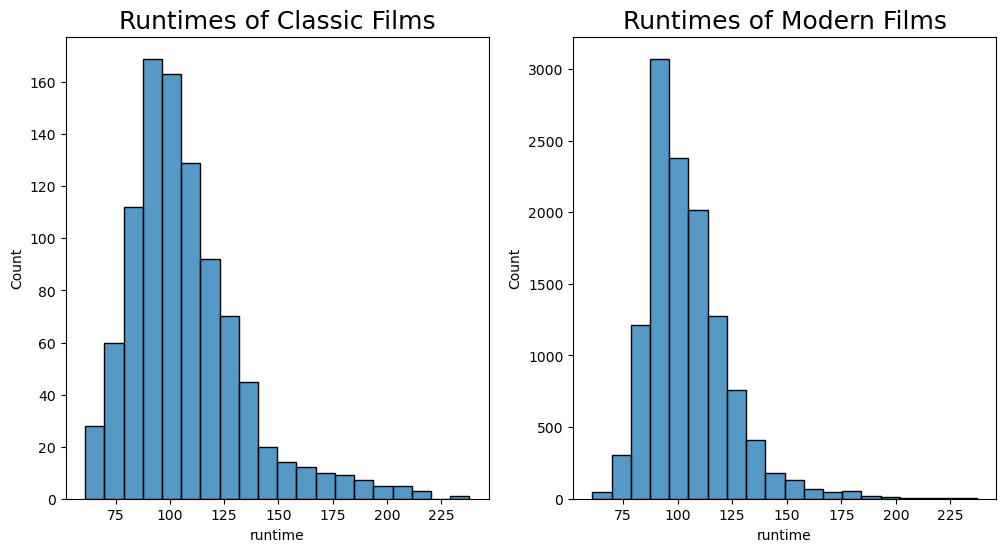

In [191]:
## Comparing runtimes for films before and after 1967

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(films[films['year']<1967]['runtime'], bins=20)
plt.title('Runtimes of Classic Films', size=18)

plt.subplot(1, 2, 2)
sns.histplot(films[films['year']>=1967]['runtime'], bins=20)
plt.title('Runtimes of Modern Films', size=18)

plt.show()

### Analysing Genres
---

In [192]:
## Converting Genre column into a list
films['genres'] = films['genres'].apply(literal_eval).apply(lambda x: [genre['name'] for genre in x])

In [193]:
### Looking at the genres included in the Genres column
set(films['genres'].sum())

## I should remove any Documentaries and TV Movies from the dataframe
## I can remove Foreign from the genres column

{'Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Foreign',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science Fiction',
 'TV Movie',
 'Thriller',
 'War',
 'Western'}

In [194]:
### Removing TV Movies and Documentaries from dataframe
films = films[films['genres'].apply(lambda x: ('TV Movie' not in x) and ('Documentary' not in x))]

In [195]:
## Removing 'Foreign' from genres column
films['genres'] = films['genres'].apply(lambda x: [i for i in x if i != 'Foreign'])

In [196]:
total_genre_count = pd.Series(films['genres'].sum()).value_counts()
total_genre_count = pd.DataFrame({'Genre':total_genre_count.index, 'Count':total_genre_count.values})
total_genre_count

,Genre,Count
0,Drama,6151
1,Comedy,4377
2,Thriller,3432
3,Action,2748
4,Romance,2129
5,Horror,1915
6,Crime,1770
7,Adventure,1660
8,Science Fiction,1311
9,Family,1075


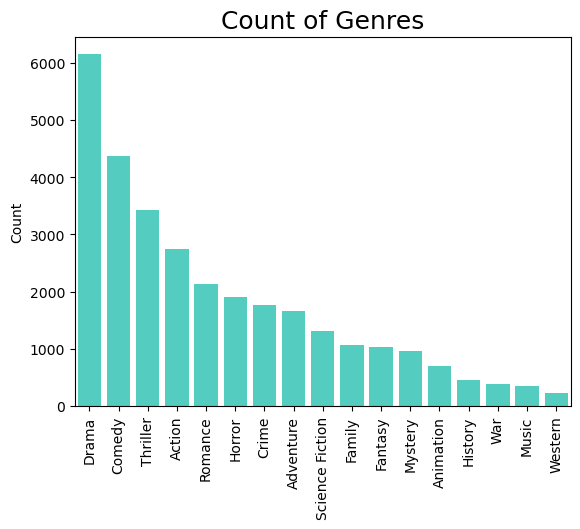

In [197]:
sns.barplot(data=total_genre_count, x='Genre', y='Count', color='turquoise')
plt.title('Count of Genres', size=18)
plt.xlabel('')
plt.xticks(rotation=90,
           fontsize =10)

plt.savefig('genres.png', dpi = 300, bbox_inches = 'tight', transparent=True)
plt.show()

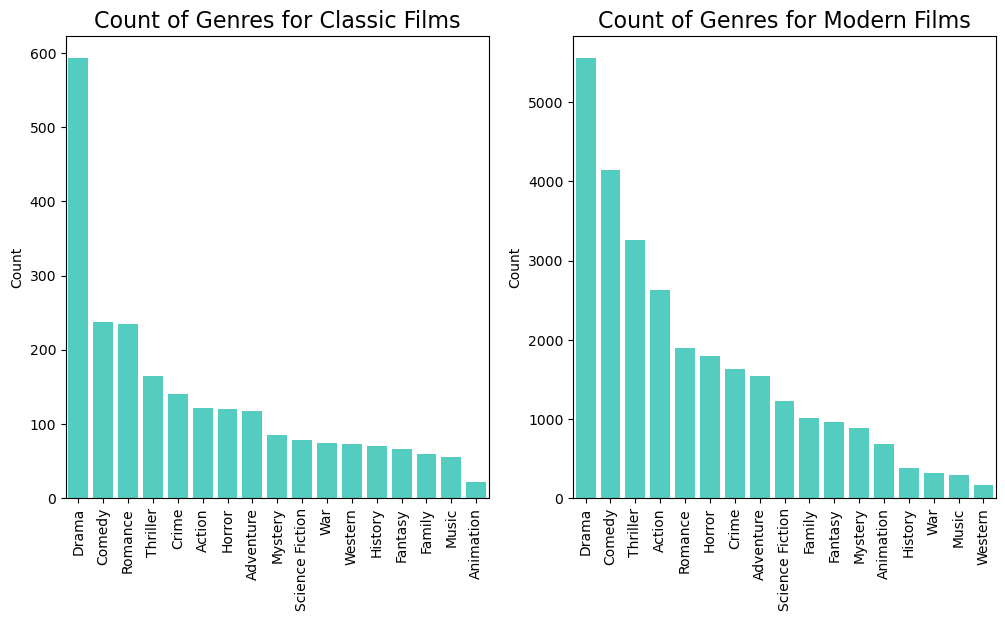

In [198]:
## Looking at Genre distributions for old/new films

classic_genre_count = pd.Series(films[films['year']<1967]['genres'].sum()).value_counts()
classic_genre_count = pd.DataFrame({'Genre':classic_genre_count.index, 'Count':classic_genre_count.values})
modern_genre_count = pd.Series(films[films['year']>=1967]['genres'].sum()).value_counts()
modern_genre_count = pd.DataFrame({'Genre':modern_genre_count.index, 'Count':modern_genre_count.values})

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(data=classic_genre_count, x='Genre', y='Count', color='turquoise')
plt.title('Count of Genres for Classic Films', size=16)
plt.xlabel('')
plt.xticks(rotation=90,
           fontsize =10)

plt.subplot(1, 2, 2)
sns.barplot(data=modern_genre_count, x='Genre', y='Count', color='turquoise')
plt.title('Count of Genres for Modern Films', size=16)
plt.xlabel('')
plt.xticks(rotation=90,
           fontsize =10)

plt.savefig('genres_split.png', dpi = 300, bbox_inches = 'tight', transparent=True)
plt.show()

In [199]:
## Converting Production Companies, Production Countries and Spoken Languages to lists

films['production_companies'] = films['production_companies'].apply(literal_eval).apply(lambda x: [co['name'] for co in x])
films['production_countries'] = films['production_countries'].apply(literal_eval).apply(lambda x: [country['name'] for country in x])
films['spoken_languages'] = films['spoken_languages'].apply(literal_eval).apply(lambda x: [lang['name'] for lang in x])

In [200]:
films.head()

,tmdbId,title,year,genres,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,runtime,spoken_languages,tagline,vote_average,vote_count,adj_rating
0,862,Toy Story,1995,"[Animation, Comedy, Family]",en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,[Pixar Animation Studios],[United States of America],81,[English],,7.7,5415,7.684640
1,8844,Jumanji,1995,"[Adventure, Fantasy, Family]",en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America],104,"[English, Français]",Roll the dice and unleash the excitement!,6.9,2413,6.872264
2,15602,Grumpier Old Men,1995,"[Romance, Comedy]",en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[Warner Bros., Lancaster Gate]",[United States of America],101,[English],Still Yelling. Still Fighting. Still Ready for...,6.5,92,5.968905
3,31357,Waiting to Exhale,1995,"[Comedy, Drama, Romance]",en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[Twentieth Century Fox Film Corporation],[United States of America],127,[English],Friends are the people who let you be yourself...,6.1,34,5.146619
4,11862,Father of the Bride Part II,1995,[Comedy],en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[Sandollar Productions, Touchstone Pictures]",[United States of America],106,[English],Just When His World Is Back To Normal... He's ...,5.7,173,5.474702


In [201]:
films['production_countries'] = films['production_countries'].apply(lambda countries: [x.replace('United States of America','USA').replace('United Kingdom','UK') for x in countries])

In [202]:
country_count = pd.Series(films['production_countries'].sum()).value_counts()
country_count = pd.DataFrame({'Country':country_count.index, 'Count':country_count.values})
country_count

,Country,Count
0,USA,8243
1,UK,1572
2,France,1399
3,Germany,774
4,Canada,618
...,...,...
104,Macao,1
105,Zimbabwe,1
106,Ecuador,1
107,Costa Rica,1


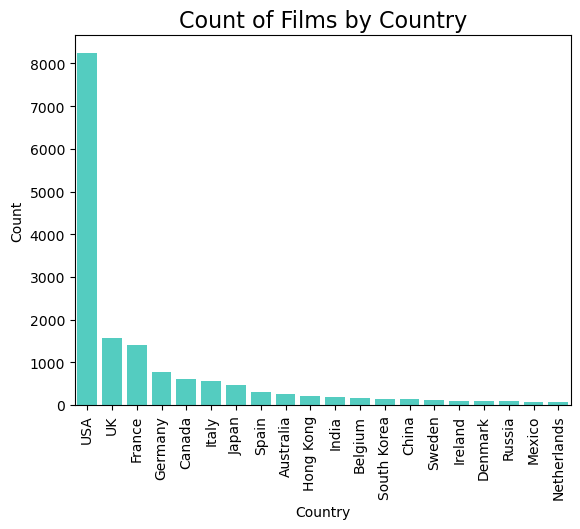

In [203]:
sns.barplot(data=country_count[0:20], x='Country', y='Count', color='turquoise')
plt.title('Count of Films by Country', size=16)
plt.xticks(rotation=90,
           fontsize =10)
plt.show()

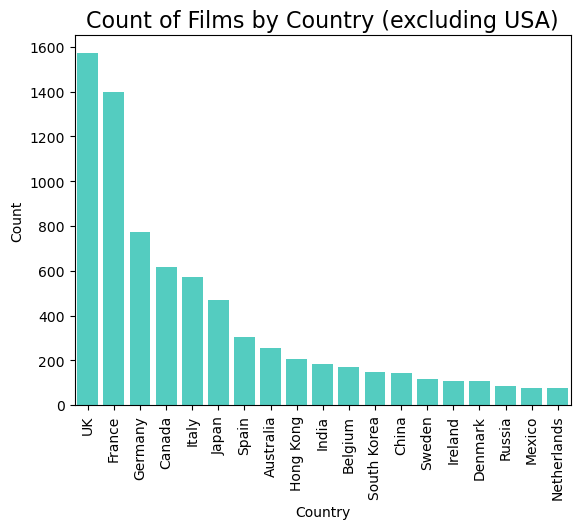

In [204]:
sns.barplot(data=country_count[1:20], x='Country', y='Count', color='turquoise')
plt.title('Count of Films by Country (excluding USA)', size=16)
plt.xticks(rotation=90,
           fontsize =10)
plt.show()

In [205]:
### films that do not give any production countries appear to all be TV movies
## However, there does appear to still be some actual films in there
## None of them were released before 1967 so leaving them in the data they will not affect the output of my model
films[films['production_countries'].map(lambda x: len(x))==0].sort_values('popularity', ascending=False)

,tmdbId,title,year,genres,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,runtime,spoken_languages,tagline,vote_average,vote_count,adj_rating
30729,21316,Leroy & Stitch,2006,"[Animation, Comedy, Family]",en,Leroy & Stitch,"Lilo, Stitch, Jumba and Pleakley have finally ...",11.193451,/84ii0eIQy8wyzo5ZOSDbnoDtQ4O.jpg,[Walt Disney Television Animation],[],73,[English],,6.5,61,5.765647
30850,24615,Aloha Scooby-Doo!,2005,"[Family, Animation]",en,Aloha Scooby-Doo!,"Scooby and the gang visit Hawaii, but a monste...",10.584972,/dILyEqHboUAaFw4T4xj6bR3rdTg.jpg,[],[],70,[English],,5.9,63,5.327921
29694,13285,Barbie Fairytopia: Mermaidia,2006,"[Animation, Family, Adventure, Fantasy]",en,Barbie Fairytopia: Mermaidia,"In this animated follow-up to Fairytopia, Elin...",10.464151,/5SnzxUarj0isswRRMgtYZRZHyYs.jpg,[],[],75,[English],,6.2,95,5.734934
45239,451955,The Double Lover,2017,[Thriller],fr,L'Amant double,"Chloé, a fragile young woman, falls in love wi...",9.907026,/fcpCBc2cDaeP23POjT44NnZZAkp.jpg,[],[],110,[Français],,6.2,72,5.618667
19017,45054,There Be Dragons,2011,[Drama],en,There Be Dragons,Arising out of the horror of the Spanish Civil...,9.531143,/dKgPtWZkHkTeYQRvLTsO0RBYaQZ.jpg,[],[],112,[English],,5.8,28,4.852446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1582,45153,Eve's Bayou,1997,[Drama],en,Eve's Bayou,The story is set in 1962 Louisiana. The big Ba...,1.461772,/bcPp0LFTQ9SNxDUvygEzmUpQ4f8.jpg,[],[],109,[English],The secrets that hold us together can also tea...,6.3,29,5.167702
38218,376292,Paradox,2016,"[Action, Science Fiction]",en,Paradox,A group of scientists are experimenting with t...,1.400155,/ljlTYcbO6tj5XfCZ9wYIRAdYFDv.jpg,[],[],90,[English],,5.0,34,4.454026
21981,96924,Aziz Ansari: Dangerously Delicious,2012,[Comedy],en,Aziz Ansari: Dangerously Delicious,Aziz Ansari channels his crude side taking on ...,1.234042,/dlZGbONABO3mMLdNewDn7uPiTfG.jpg,[],[],61,[English],,7.4,26,5.715596
13855,24232,Is It College Yet?,2002,"[Animation, Comedy]",en,Is It College Yet?,"All vile things must come to an end, and for D...",0.782377,/68rPk1cGkHAgrFsoXxxB4Q43vPK.jpg,[],[],90,[],,7.4,26,5.715596


### Cleaning Ratings Dataframe
---

In [206]:
## Adding tmdbId to ratings dataframe so I can join with the films dataframe
ratings = ratings.join(links[['movieId','tmdbId']].set_index('movieId'), on='movieId')
ratings.head()

,userId,movieId,rating,timestamp,tmdbId
0,1,110,1.0,1425941529,197.0
1,1,147,4.5,1425942435,10474.0
2,1,858,5.0,1425941523,238.0
3,1,1221,5.0,1425941546,240.0
4,1,1246,5.0,1425941556,207.0


In [207]:
## Adding Title and Year to the ratings dataframe
ratings = ratings.join(films[['tmdbId','title','year','production_countries']].set_index('tmdbId'), on='tmdbId')

In [208]:
ratings.head()

,userId,movieId,rating,timestamp,tmdbId,title,year,production_countries
0,1,110,1.0,1425941529,197.0,Braveheart,1995.0,[USA]
1,1,147,4.5,1425942435,10474.0,The Basketball Diaries,1995.0,[USA]
2,1,858,5.0,1425941523,238.0,The Godfather,1972.0,[USA]
3,1,1221,5.0,1425941546,240.0,The Godfather: Part II,1974.0,[USA]
4,1,1246,5.0,1425941556,207.0,Dead Poets Society,1989.0,[USA]


In [209]:
## Removing ratings for films that are no longer in the films dataframe
ratings.dropna(subset='title', inplace=True)
ratings['year'] = ratings['year'].astype(int)

In [210]:
len(ratings)

4750774

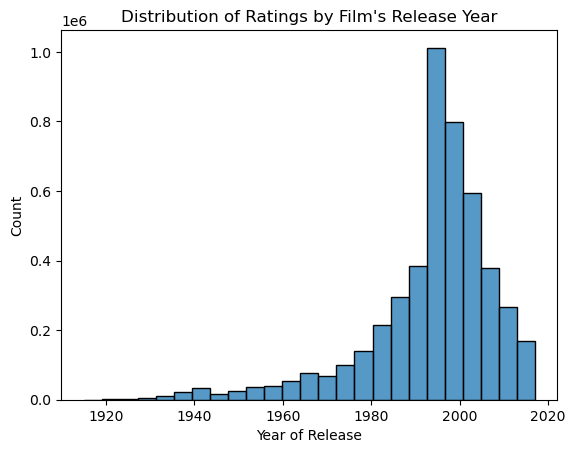

In [211]:
sns.histplot(ratings['year'], bins=25)
plt.title("Distribution of Ratings by Film's Release Year")
plt.xlabel('Year of Release')
plt.savefig('years_ratings.png', dpi = 300, bbox_inches = 'tight', transparent=True)
plt.show()

In [212]:
## Adding keywords to films dataframe
films = films.join(keywords.set_index('id'), on='tmdbId')

In [213]:
## Converting keywords to lists
films['keywords'] = films['keywords'].apply(literal_eval)
films['keywords'] = films['keywords'].apply(lambda x: [key['name'] for key in x])

In [214]:
films['keywords'].head()

0    [jealousy, toy, boy, friendship, friends, riva...
1    [board game, disappearance, based on children'...
2    [fishing, best friend, duringcreditsstinger, o...
3    [based on novel, interracial relationship, sin...
4    [baby, midlife crisis, confidence, aging, daug...
Name: keywords, dtype: object

In [215]:
def label_international(countries, languages):
    """A function to provide a label for international films
    Input: The list of productions countries and spoken languages for a film
    Output: 1 for international films, 0 for English films

    The function allows for an English-speaking country to appear in the production companies if the spoken languages does not include English.
    A film that includes spoken English will still count as international if the production companies do not include any English-speaking countries and English is not the only spoken language.
    """

    # Check for English-speaking countries in the production countries
    c_intersect = [country for country in countries if country in ['USA','UK','Australia','New Zealand']]
    # Check if the film contains spoken English, or no spoken language
    l_intersect = [lang for lang in languages if lang in ['English','No Language']]

    if languages == ['English']:
        label = 0 ## Films with English as the only spoken language
    elif len(c_intersect) > 0 and len(l_intersect) > 0:
        label = 0 ## Films from an English-speaking country, with spoken English
    elif languages==[] or countries==[]:
        label = 0 ## Do not label any rows where country/language data is potentially incomplete
    else:
        label = 1
    return label

In [216]:
## Applying labelling function to films dataframe
films['international'] = films.apply(lambda x: label_international(x['production_countries'],x['spoken_languages']), axis=1)

In [217]:
len(films[films['international']==1])

2880

In [218]:
## Checking films labelled as international
films[films['international']==1][['title','production_countries','spoken_languages']]

,title,production_countries,spoken_languages
28,The City of Lost Children,"[France, Germany, Spain]","[广州话 / 廣州話, Français]"
57,The Postman,"[Belgium, France, Italy]","[Italiano, Español]"
67,French Twist,[France],"[Français, Español]"
81,Antonia's Line,"[Netherlands, UK, Belgium]",[Nederlands]
95,La Haine,[France],[Français]
...,...,...,...
45244,Pippi Longstocking,[Sweden],"[svenska, Deutsch]"
45268,"Good Guys Go to Heaven, Bad Guys Go to Pattaya",[France],[Français]
45331,The Olive Tree,"[Germany, Spain]",[Español]
45339,With Open Arms,[France],"[English, Français, Pусский]"


In [219]:
films['title_lower'] = films['title'].str.lower().str.replace('[{}]'.format(string.punctuation),'',regex=True).apply(unidecode)

# Creating a Basic Model
---

In [220]:
df_films = films.copy()

<b>Possible Features:</b>
- Genres
- Production Countries
- Spoken Languages
- Runtime
- Keywords
- Overview
- Tagline


### Preparing Summary
---

In [221]:
def concatenate(x):
    """a function to combine text-based features into a single string
    Input: separate string for Overview & Tagline, and a list of Keywords
    Output: Overview, Tagline and all Keywords in one string
    """
    return x['overview'] + ' ' + x['tagline'] + ' ' + ' '.join(x['keywords'])

In [222]:
## Create summary column containing all text besides genre
## Genre will be weighted separately
df_films['summary'] = df_films.apply(concatenate, axis=1)

In [223]:
p_stemmer = PorterStemmer()
stpwrd = nltk.corpus.stopwords.words('english')
stpwrd.extend(string.punctuation)

def prep_summary(summary):
    """Function to prepare the Summary
    Input: single string of text
    Output: string of text in lower case, stop words removed, and stemmed
    """
    summary = summary.lower()
    summary = word_tokenize(summary)
    summary = [word for word in summary if word not in stpwrd]
    summary = [p_stemmer.stem(word) for word in summary]
    summary = [word for word in summary if word not in stpwrd]
    summary = [word for word in summary if word not in ['film','movie']]
    summary = [word for word in summary if len(word)>2]
    return ' '.join(summary)

In [224]:
df_films['summary'] = df_films['summary'].apply(prep_summary)

In [225]:
## Creating alternative summary where keywords are included twice

def concatenate2(x):
    """a function to combine text-based features into a single string, with keywords included twice
    Input: separate string for Overview & Tagline, and a list of Keywords
    Output: Overview, Tagline and all Keywords (duplicated) in one string
    """
    return x['overview'] + ' ' + x['tagline'] + ' ' + ' '.join(x['keywords']) + ' ' + ' '.join(x['keywords'])

df_films['summary2'] = df_films.apply(concatenate2, axis=1)
df_films['summary2'] = df_films['summary2'].apply(prep_summary)

### Calculating Similarity Scores
---

In [226]:
## Replace 'Science Fiction' with 'Sci-Fi' so it does not affect similarity scores
df_films['genres'] = df_films['genres'].apply(lambda x: ' '.join(x)).str.replace('Science Fiction','Sci-Fi')

In [227]:
## Sort dataframe by year and reindex
## This will make it easier to return only older films in the function
df_films = df_films.sort_values('year')
df_films = df_films.reset_index()
df_films.head()

,index,tmdbId,title,year,genres,original_language,original_title,overview,popularity,poster_path,...,spoken_languages,tagline,vote_average,vote_count,adj_rating,keywords,international,title_lower,summary,summary2
0,6913,618,The Birth of a Nation,1915,Drama History War,en,The Birth of a Nation,The Birth of A Nation is a silent film from 19...,5.113205,/zYtgDRSOQeZmGbHkXff5CcEg05g.jpg,...,[No Language],The fiery cross of the Ku Klux Klan.,6.4,109,5.954398,"[ku klux klan, southern usa, patriotism, army,...",0,the birth of a nation,birth nation silent 1915 highest gross silent ...,birth nation silent 1915 highest gross silent ...
1,7090,3059,Intolerance: Love's Struggle Throughout the Ages,1916,Drama,en,Intolerance: Love's Struggle Throughout the Ages,"The story of a poor young woman, separated by ...",4.282118,/pnUj8htRLf53aNuFV5vkiWRCrfn.jpg,...,[No Language],The Cruel Hand of Intolerance,7.4,63,6.466475,"[usa, naivety, intolerance, mill, marriage, we...",0,intolerance loves struggle throughout the ages,stori poor young woman separ prejudic husband ...,stori poor young woman separ prejudic husband ...
2,6836,899,Broken Blossoms,1919,Drama Romance,en,Broken Blossoms,Broken Blossoms is an American silent film fro...,3.185824,/sr5yZl89NOtkXiZEyvNx5uz9JvB.jpg,...,[No Language],,6.9,41,5.793728,"[london england, suicide, china, boxer, buddhi...",0,broken blossoms,broken blossom american silent director griffi...,broken blossom american silent director griffi...
3,6835,234,The Cabinet of Dr. Caligari,1920,Drama Horror Thriller Crime,de,Das Cabinet des Dr. Caligari,The Cabinet of Dr. Caligari is eerie and expre...,7.191271,/myK9DeIsXWGKgUTZyGXg2IfFk0W.jpg,...,[No Language],You must become Caligari.,7.7,279,7.420794,"[insane asylum, silent film, unreliable narrat...",1,the cabinet of dr caligari,cabinet dr. caligari eeri expressionist silent...,cabinet dr. caligari eeri expressionist silent...
4,8295,2972,The Golem: How He Came Into the World,1920,Horror Sci-Fi Thriller,de,"Der Golem, wie er in die Welt kam","In the 16th century, the Jews of Prague face p...",1.524130,/gzXqhVnd3RfroaSm0btYN0lrVTt.jpg,...,[No Language],The 1920 Horror Masterpiece,7.0,29,5.581988,[in vitro fertilisation],1,the golem how he came into the world,16th centuri jew pragu face persecut rabbi loe...,16th centuri jew pragu face persecut rabbi loe...


In [228]:
## Converting production countries into a single string for better display
df_films['country'] = df_films['production_countries'].apply(lambda x: ', '.join(x))
ratings['country'] = ratings['production_countries'].apply(lambda x: ', '.join(x))

In [229]:
df_films.head()

,index,tmdbId,title,year,genres,original_language,original_title,overview,popularity,poster_path,...,tagline,vote_average,vote_count,adj_rating,keywords,international,title_lower,summary,summary2,country
0,6913,618,The Birth of a Nation,1915,Drama History War,en,The Birth of a Nation,The Birth of A Nation is a silent film from 19...,5.113205,/zYtgDRSOQeZmGbHkXff5CcEg05g.jpg,...,The fiery cross of the Ku Klux Klan.,6.4,109,5.954398,"[ku klux klan, southern usa, patriotism, army,...",0,the birth of a nation,birth nation silent 1915 highest gross silent ...,birth nation silent 1915 highest gross silent ...,USA
1,7090,3059,Intolerance: Love's Struggle Throughout the Ages,1916,Drama,en,Intolerance: Love's Struggle Throughout the Ages,"The story of a poor young woman, separated by ...",4.282118,/pnUj8htRLf53aNuFV5vkiWRCrfn.jpg,...,The Cruel Hand of Intolerance,7.4,63,6.466475,"[usa, naivety, intolerance, mill, marriage, we...",0,intolerance loves struggle throughout the ages,stori poor young woman separ prejudic husband ...,stori poor young woman separ prejudic husband ...,USA
2,6836,899,Broken Blossoms,1919,Drama Romance,en,Broken Blossoms,Broken Blossoms is an American silent film fro...,3.185824,/sr5yZl89NOtkXiZEyvNx5uz9JvB.jpg,...,,6.9,41,5.793728,"[london england, suicide, china, boxer, buddhi...",0,broken blossoms,broken blossom american silent director griffi...,broken blossom american silent director griffi...,USA
3,6835,234,The Cabinet of Dr. Caligari,1920,Drama Horror Thriller Crime,de,Das Cabinet des Dr. Caligari,The Cabinet of Dr. Caligari is eerie and expre...,7.191271,/myK9DeIsXWGKgUTZyGXg2IfFk0W.jpg,...,You must become Caligari.,7.7,279,7.420794,"[insane asylum, silent film, unreliable narrat...",1,the cabinet of dr caligari,cabinet dr. caligari eeri expressionist silent...,cabinet dr. caligari eeri expressionist silent...,Germany
4,8295,2972,The Golem: How He Came Into the World,1920,Horror Sci-Fi Thriller,de,"Der Golem, wie er in die Welt kam","In the 16th century, the Jews of Prague face p...",1.524130,/gzXqhVnd3RfroaSm0btYN0lrVTt.jpg,...,The 1920 Horror Masterpiece,7.0,29,5.581988,[in vitro fertilisation],1,the golem how he came into the world,16th centuri jew pragu face persecut rabbi loe...,16th centuri jew pragu face persecut rabbi loe...,Germany


In [230]:
## Creating a separate dataframe for international films be reordering and reindexing
df_international = df_films.sort_values('international', ascending=False).copy()
df_international = df_international.reset_index()
df_international.head()

,level_0,index,tmdbId,title,year,genres,original_language,original_title,overview,popularity,...,tagline,vote_average,vote_count,adj_rating,keywords,international,title_lower,summary,summary2,country
0,9708,20400,110398,No,2012,Drama History,es,No,"In 1988, Chilean military dictator Augusto Pin...",5.979660,...,"¡Adiós, Pinochet!",7.0,132,6.542878,"[opression, campaign, chile, dictatorship, pin...",1,no,1988 chilean militari dictat augusto pinochet ...,1988 chilean militari dictat augusto pinochet ...,"Mexico, Chile, France, USA"
1,3660,9049,8983,Felidae,1994,Animation Mystery Thriller,de,Felidae,A domestic house cat named Francis investigate...,2.225467,...,The cat thriller!,6.3,31,5.212106,"[detective, cat, computer, revier, murder, ext...",1,felidae,domest hous cat name franci investig grisli fe...,domest hous cat name franci investig grisli fe...,Germany
2,9585,19793,121793,Capital,2012,Drama,fr,Le capital,The head of a giant European investment bank d...,4.194984,...,,5.4,53,4.886540,[],1,capital,head giant european invest bank desper cling p...,head giant european invest bank desper cling p...,France
3,9582,31542,137315,Every Blessed Day,2012,Comedy,it,Tutti i santi giorni,Guido and Antonia are a young couple with oppo...,3.211308,...,,7.1,59,6.195157,[],1,every blessed day,guido antonia young coupl oppos charact work s...,guido antonia young coupl oppos charact work s...,Italy
4,3635,632,11479,"Little Indian, Big City",1994,Adventure Drama Comedy Family,fr,Un indien dans la ville,"Stephen, an international trader, tracks down ...",4.728163,...,The city is a jungle. Some are just better pre...,6.0,145,5.700105,"[paris, father son relationship, amazon, jungl...",1,little indian big city,stephen intern trader track ex-wif patricia am...,stephen intern trader track ex-wif patricia am...,France


In [231]:
## Setting number of rows of the dataframe to be considered in the output
n = len(df_films[df_films['year']<1967])
n

950

In [232]:
### Cosine Similarity for Overview
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
overview_matrix = tf.fit_transform(df_films['overview'])
overview_sim = linear_kernel(overview_matrix, overview_matrix[0:n])

In [233]:
### Cosine Similarity for Summary
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
summary_matrix = tf.fit_transform(df_films['summary'])
summary_sim = linear_kernel(summary_matrix, summary_matrix[0:n])

In [234]:
### Cosine Similarity for Summary2
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
summary2_matrix = tf.fit_transform(df_films['summary2'])
summary2_sim = linear_kernel(summary2_matrix, summary2_matrix[0:n])

In [235]:
### Cosine Similarity for Genres
tf = TfidfVectorizer(analyzer='word', min_df=0, stop_words=None)
genre_matrix = tf.fit_transform(df_films['genres'])
genre_sim = linear_kernel(genre_matrix, genre_matrix[0:n])

In [236]:
### Cosine Similarity for Summary2, using Count Vectorizer
count = CountVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
summary2_matrix = count.fit_transform(df_films['summary2'])
summary2_count_sim = linear_kernel(summary2_matrix, summary2_matrix[0:n])

In [237]:
list(zip(summary2_sim[0], summary2_count_sim[0]))[0:20]

[(0.9999999999999992, 199.0),
 (0.05076002109263174, 16.0),
 (0.06100656494645775, 16.0),
 (0.03803824779237567, 13.0),
 (0.020453535239566546, 4.0),
 (0.05592485775816333, 15.0),
 (0.03055943238727401, 14.0),
 (0.0, 0.0),
 (0.03157826263007858, 15.0),
 (0.038723109886311946, 11.0),
 (0.004664981199318105, 2.0),
 (0.056440824276246034, 8.0),
 (0.028066335569339306, 8.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.025406289078945928, 10.0),
 (0.04028184619020698, 10.0),
 (0.021332148335584424, 8.0),
 (0.0, 0.0),
 (0.04788195537750136, 14.0)]

In [238]:
### Cosine Similarity for Genres, using Count Vectorizer
count = CountVectorizer(analyzer='word', min_df=0, stop_words=None)
genre_matrix = count.fit_transform(df_films['genres'])
genre_count_sim = linear_kernel(genre_matrix, genre_matrix[0:n])

In [239]:
### Cosine Similarities for International films

n = len(df_films[df_films['international']==1])

### Summary2
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
inter_summary2_matrix = tf.fit_transform(df_international['summary2'])
inter_summary2_sim = linear_kernel(inter_summary2_matrix, inter_summary2_matrix[0:n])

### Genres
tf = TfidfVectorizer(analyzer='word', min_df=0, stop_words=None)
inter_genre_matrix = tf.fit_transform(df_international['genres'])
inter_genre_sim = linear_kernel(inter_genre_matrix, inter_genre_matrix[0:n])

In [240]:
### Jaccard Similarity for Genres
# tf = CountVectorizer()
# genre_jac_matrix = tf.fit_transform(df_films['genres'])
# genre_jac_sim = []
# for i in range(len(df_films)):
#     jaccard_sim_row = []
#     for j in range(len(df_films[df_films['release_date']<1967])):
#         jaccard_sim = jaccard_score(genre_jac_matrix[i].toarray()[0], genre_jac_matrix[j].toarray()[0])
#         jaccard_sim_row.append(jaccard_sim)
#     genre_jac_sim.append(jaccard_sim_row)


##### Takes far too long to run

In [241]:
summary_sim.mean()

0.0037006971293055283

In [242]:
summary2_sim.mean()

0.0036533168400365093

In [243]:
genre_sim.mean()

0.19234988345461382

### Creating Models
---

In [244]:
def similar(film, international=False):
    """retrieves cosine score for summary (2*keywords) & genres
    final score by calculating product
    returns 10 most similar, then sorts by ratings"""

    if international:
        df = df_international
        sum_sims = inter_summary2_sim
        gen_sims = inter_genre_sim
    else:
        df = df_films
        sum_sims = summary2_sim
        gen_sims = genre_sim

    film = unidecode(re.sub(r'[{}]'.format(string.punctuation),'',film.lower()))

    ## retrieve film id
    if len(df[df['title_lower']==film].index) == 0:
        return 'This film could not be found.'
    elif len(df[df['title_lower']==film].index) > 1:
        year = int(input("What year was this film released?"))
        input_id = df[df['title_lower']==film]['year'].apply(lambda x: abs(x-year)).idxmin()
    else:
        input_id = df[df['title_lower']==film].index[0]
    print('Giving recommendations for ' + str(df['title'].iloc[input_id]) + ' (' + str(df['year'].iloc[input_id]) + ')')

    ## calculate metric scores
    summary_scores = sum_sims[input_id]
    genre_scores = gen_sims[input_id]

    ## combine into final scores
    scores = summary_scores * genre_scores
    scores = list(enumerate(scores))

    ## retrieve 10 highest scores
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    indices = [i[0] for i in scores[0:10]]
    output = df[['title','year','genres','tmdbId','adj_rating','country']].iloc[indices]

    return output.reset_index()[['title','year','country']]

Model 1: Basic Model, scoring by Overview * Genre

In [245]:
def recommend1(film):
    """retrieves cosine score for overview & genres
    final score by calculating product
    returns 10 most similar, then sorts by ratings"""
    ## retrieve film id
    input_id = df_films[df_films['title']==film].index.max()
    tmdb_id = df_films['tmdbId'].iloc[input_id]

    ## calculate metric scores
    overview_scores = overview_sim[input_id]
    genre_scores = genre_sim[input_id]

    ## combine into final scores
    scores = overview_scores * genre_scores
    scores = list(enumerate(scores))

    ## retrieve 10 highest scores
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    scores = scores[0:10]

    ## retrieve related films
    indices = [i[0] for i in scores]
    output = df_films[['title','year','genres','tmdbId']].iloc[indices]

    ## reorder output using collaborative filtering
    similar_users = set(ratings[(ratings['tmdbId']==tmdb_id) & (ratings['rating']>=4.5)]['userId'])
    mean_ratings = ratings[(ratings['userId'].isin(similar_users)) & (ratings['tmdbId'].isin(output['tmdbId']))].groupby('tmdbId')[['title','rating']].agg(title=('title','first'), mean=('rating','mean'), count=('rating','count'))
    mean_ratings['adj_rating'] = mean_ratings.apply(lambda x: (x['mean']*x['count']/(x['count']+m))+(C*m/(x['count']+m)), axis=1)
    return mean_ratings.sort_values(by='adj_rating', ascending=False)
    # return output

Model 2: adding Tagline & Keywords, scoring by Summary * Genre

In [246]:
def recommend2(film):
    """retrieves cosine score for summary & genres
    final score by calculating product
    returns 10 most similar, then sorts by ratings"""

    ## retrieve film id
    if len(df_films[df_films['title']==film].index) == 0:
        return 'Unable to find the film.'
    elif len(df_films[df_films['title']==film].index) > 1:
        year = int(input("What year was this film released?"))
        input_id = df_films[df_films['title']==film]['year'].apply(lambda x: abs(x-year)).idxmin()
    else:
        input_id = df_films[df_films['title']==film].index[0]
    print('Showing recommendations for ' + str(df_films['title'].iloc[input_id]) + ' (' + str(df_films['year'].iloc[input_id]) + ')')

    ## calculate metric scores
    summary_scores = summary_sim[input_id]
    genre_scores = genre_sim[input_id]

    ## combine into final scores
    scores = summary_scores * genre_scores
    scores = list(enumerate(scores))

    ## retrieve 10 highest scores
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    indices = [i[0] for i in scores[0:10]]
    output = df_films[['title','year','genres','tmdbId','vote_average']].iloc[indices]

    ## reorder output using collaborative filtering
    ## collect relevant user ratings
    tmdb_id = df_films['tmdbId'].iloc[input_id]
    similar_users = set(ratings[(ratings['tmdbId']==tmdb_id) & (ratings['rating']>=4.5)]['userId'])
    mean_ratings = ratings[(ratings['userId'].isin(similar_users)) & (ratings['tmdbId'].isin(output['tmdbId']))]

    if mean_ratings['title'].nunique() < 8:
        return output.sort_values('vote_average',ascending=False)[0:5]
    else:
        mean_ratings = mean_ratings.groupby('tmdbId')[['title','rating','year']].agg(title=('title','first'), year=('year','first'), mean=('rating','mean'), count=('rating','count'))
        mean_ratings['adj_rating'] = mean_ratings.apply(lambda x: adjust_rating(x['mean'],x['count']), axis=1)
        return mean_ratings.sort_values(by='adj_rating', ascending=False).iloc[0:5]

Model 3: scoring by Summary + Genre/2

In [247]:
def recommend3(film):
    """retrieves cosine score for summary & genres
    final score is SUMMARY + 0.5 * GENRE
    returns 10 most similar, then sorts by ratings"""

    ## retrieve film id
    if len(df_films[df_films['title']==film].index) == 0:
        return 'Unable to find the film.'
    elif len(df_films[df_films['title']==film].index) > 1:
        year = int(input("What year was this film released?"))
        input_id = df_films[df_films['title']==film]['year'].apply(lambda x: abs(x-year)).idxmin()
    else:
        input_id = df_films[df_films['title']==film].index[0]
    print('Showing recommendations for ' + str(df_films['title'].iloc[input_id]) + ' (' + str(df_films['year'].iloc[input_id]) + ')')

    ## calculate metric scores
    summary_scores = summary_sim[input_id]
    genre_scores = genre_sim[input_id]

    ## combine into final scores
    scores = summary_scores + 0.5*genre_scores
    scores = list(enumerate(scores))

    ## retrieve 10 highest scores
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    indices = [i[0] for i in scores[0:10]]
    output = df_films[['title','year','genres','tmdbId']].iloc[indices]

    ## reorder output using collaborative filtering
    ## collect relevant user ratings
    tmdb_id = df_films['tmdbId'].iloc[input_id]
    similar_users = set(ratings[(ratings['tmdbId']==tmdb_id) & (ratings['rating']>=4.5)]['userId'])
    mean_ratings = ratings[(ratings['userId'].isin(similar_users)) & (ratings['tmdbId'].isin(output['tmdbId']))]

    if mean_ratings['title'].nunique() < 8:
        return output
    else:
        mean_ratings = mean_ratings.groupby('tmdbId')[['title','rating','year']].agg(title=('title','first'), year=('year','first'), mean=('rating','mean'), count=('rating','count'))
        mean_ratings['adj_rating'] = mean_ratings.apply(lambda x: adjust_rating(x['mean'],x['count']), axis=1)
        return mean_ratings.sort_values(by='adj_rating', ascending=False).iloc[0:5]

Model 4: scoring by Summary + Genre/100

In [248]:
def recommend4(film):
    """retrieves cosine score for summary & genres
    final score is SUMMARY + 0.01 * GENRE
    returns 10 most similar, then sorts by ratings"""

    ## retrieve film id
    if len(df_films[df_films['title']==film].index) == 0:
        return 'Unable to find the film.'
    elif len(df_films[df_films['title']==film].index) > 1:
        year = int(input("What year was this film released?"))
        input_id = df_films[df_films['title']==film]['year'].apply(lambda x: abs(x-year)).idxmin()
    else:
        input_id = df_films[df_films['title']==film].index[0]
    print('Showing recommendations for ' + str(df_films['title'].iloc[input_id]) + ' (' + str(df_films['year'].iloc[input_id]) + ')')

    ## calculate metric scores
    summary_scores = summary_sim[input_id]
    genre_scores = genre_sim[input_id]

    ## combine into final scores
    scores = summary_scores + 0.01*genre_scores
    scores = list(enumerate(scores))

    ## retrieve 10 highest scores
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    indices = [i[0] for i in scores[0:10]]
    output = df_films[['title','year','genres','tmdbId']].iloc[indices]

    ## reorder output using collaborative filtering
    ## collect relevant user ratings
    tmdb_id = df_films['tmdbId'].iloc[input_id]
    similar_users = set(ratings[(ratings['tmdbId']==tmdb_id) & (ratings['rating']>=4.5)]['userId'])
    mean_ratings = ratings[(ratings['userId'].isin(similar_users)) & (ratings['tmdbId'].isin(output['tmdbId']))]

    if mean_ratings['title'].nunique() < 8:
        return output
    else:
        mean_ratings = mean_ratings.groupby('tmdbId')[['title','rating','year']].agg(title=('title','first'), year=('year','first'), mean=('rating','mean'), count=('rating','count'))
        mean_ratings['adj_rating'] = mean_ratings.apply(lambda x: adjust_rating(x['mean'],x['count']), axis=1)
        return mean_ratings.sort_values(by='adj_rating', ascending=False).iloc[0:5]

Model 5: after duplicating Keywords, scoring by Summary * Genre

In [249]:
def recommend5(film):
    """retrieves cosine score for summary (2*keywords) & genres
    final score by calculating product
    returns 10 most similar, then sorts by ratings"""

    ## retrieve film id
    if len(df_films[df_films['title']==film].index) == 0:
        return 'Unable to find the film.'
    elif len(df_films[df_films['title']==film].index) > 1:
        year = int(input("What year was this film released?"))
        input_id = df_films[df_films['title']==film]['year'].apply(lambda x: abs(x-year)).idxmin()
    else:
        input_id = df_films[df_films['title']==film].index[0]
    print('Showing recommendations for ' + str(df_films['title'].iloc[input_id]) + ' (' + str(df_films['year'].iloc[input_id]) + ')')

    ## calculate metric scores
    summary_scores = summary2_sim[input_id]
    genre_scores = genre_sim[input_id]

    ## combine into final scores
    scores = summary_scores * genre_scores
    scores = list(enumerate(scores))

    ## retrieve 10 highest scores
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    indices = [i[0] for i in scores[0:10]]
    output = df_films[['title','year','genres','tmdbId','vote_average']].iloc[indices]

    ## reorder output using collaborative filtering
    ## collect relevant user ratings
    tmdb_id = df_films['tmdbId'].iloc[input_id]
    similar_users = set(ratings[(ratings['tmdbId']==tmdb_id) & (ratings['rating']>=4.5)]['userId'])
    mean_ratings = ratings[(ratings['userId'].isin(similar_users)) & (ratings['tmdbId'].isin(output['tmdbId']))]

    if mean_ratings['title'].nunique() < 8:
        output = output.sort_values('vote_average',ascending=False)[0:5]
        return output.reset_index()[['title','year']]
    else:
        mean_ratings = mean_ratings.groupby('tmdbId')[['title','rating','year']].agg(title=('title','first'), year=('year','first'), mean=('rating','mean'), count=('rating','count'))
        mean_ratings['adj_rating'] = mean_ratings.apply(lambda x: adjust_rating(x['mean'],x['count']), axis=1)
        mean_ratings = mean_ratings.sort_values(by='adj_rating', ascending=False).iloc[0:5]
        return mean_ratings.reset_index()[['title','year']]

Model 6: adding option to recommend international films

In [250]:
def recommend(film, international=False):
    """retrieves cosine score for summary (2*keywords) & genres
    final score by calculating product
    returns 10 most similar, then sorts by ratings"""

    if international:
        df = df_international
        sum_sims = inter_summary2_sim
        gen_sims = inter_genre_sim
    else:
        df = df_films
        sum_sims = summary2_sim
        gen_sims = genre_sim

    film = unidecode(re.sub(r'[{}]'.format(string.punctuation),'',film.lower()))

    ## retrieve film id
    if len(df[df['title_lower']==film].index) == 0:
        return 'This film could not be found.'
    elif len(df[df['title_lower']==film].index) > 1:
        year = int(input("What year was this film released?"))
        input_id = df[df['title_lower']==film]['year'].apply(lambda x: abs(x-year)).idxmin()
    else:
        input_id = df[df['title_lower']==film].index[0]
    print('Giving recommendations for ' + str(df['title'].iloc[input_id]) + ' (' + str(df['year'].iloc[input_id]) + ')')

    ## calculate metric scores
    summary_scores = sum_sims[input_id]
    genre_scores = gen_sims[input_id]

    ## combine into final scores
    scores = summary_scores * genre_scores
    scores = list(enumerate(scores))

    ## retrieve 10 highest scores
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    indices = [i[0] for i in scores[0:10]]
    output = df[['title','year','genres','tmdbId','adj_rating','country']].iloc[indices]

    ## reorder output using collaborative filtering
    ## collect relevant user ratings
    tmdb_id = df['tmdbId'].iloc[input_id]
    similar_users = set(ratings[(ratings['tmdbId']==tmdb_id) & (ratings['rating']>=4.5)]['userId'])
    mean_ratings = ratings[(ratings['userId'].isin(similar_users)) & (ratings['tmdbId'].isin(output['tmdbId']))]

    if mean_ratings['title'].nunique() < 8:
        output = output.sort_values('adj_rating',ascending=False)[0:5]
        return output.reset_index()[['title','year','country']]
    else:
        mean_ratings = mean_ratings.groupby('tmdbId')[['title','rating','year','country']].agg(title=('title','first'), year=('year','first'), country=('country','first'), mean=('rating','mean'), count=('rating','count'))
        mean_ratings['adj_rating'] = mean_ratings.apply(lambda x: adjust_rating(x['mean'],x['count']), axis=1)
        mean_ratings = mean_ratings.sort_values(by='adj_rating', ascending=False).iloc[0:5]
        return mean_ratings.reset_index()[['title','year','country']]

### Testing
---

In [251]:
recommend("Frozen")
## Returns other Disney princess films

Giving recommendations for Frozen (2013)


,title,year,country
0,Sleeping Beauty,1959,USA
1,Cinderella,1950,USA
2,Snow White and the Seven Dwarfs,1937,USA
3,Alice in Wonderland,1951,USA
4,The Court Jester,1955,USA


In [252]:
recommend("You've Got Mail")
## Returns The Shop Around the Corner as expected.

Giving recommendations for You've Got Mail (1998)


,title,year,country
0,Roman Holiday,1953,USA
1,The Shop Around the Corner,1940,USA
2,The Apartment,1960,USA
3,I Was a Male War Bride,1949,USA
4,That Touch of Mink,1962,USA


In [253]:
### Skyfall
### part of the James Bond franchise
recommend("Skyfall")

Giving recommendations for Skyfall (2012)


,title,year,country
0,Goldfinger,1964,"UK, USA"
1,From Russia with Love,1963,UK
2,Dr. No,1962,UK
3,The Guns of Navarone,1961,"UK, USA"
4,Thunderball,1965,"Bahamas, France, UK, USA"


In [254]:
### The Thing
### remake of The Thing from Another World (1951)
recommend("The Thing")

Giving recommendations for The Thing (1982)


,title,year,country
0,Invasion of the Body Snatchers,1956,USA
1,The Thing from Another World,1951,USA
2,The War of the Worlds,1953,USA
3,Quatermass II,1957,UK
4,This Island Earth,1955,USA


In [255]:
### The Departed
### remake of Infernal Affairs (Hong Kong)
recommend("The Departed", international=True)

Giving recommendations for The Departed (2006)


,title,year,country
0,Infernal Affairs,2002,Hong Kong
1,The Raid 2,2014,Indonesia
2,New World,2013,South Korea
3,Infernal Affairs II,2003,"China, Hong Kong, Singapore"
4,36th Precinct,2004,France


In [256]:
### The Magnificent Seven
### remake of Seven Samurai (Japan)
recommend("The Magnificent Seven", international=True)

## The function does not return Seven Samurai
## Instead, it recommends other Westerns

Giving recommendations for The Magnificent Seven (1960)


,title,year,country
0,"The Good, the Bad and the Ugly",1966,"USA, Italy, Spain, Germany"
1,A Fistful of Dollars,1964,"Italy, Germany, Spain"
2,"Duck, You Sucker",1971,Italy
3,El Topo,1970,Mexico
4,"The Good, The Bad, The Weird",2008,South Korea


In [273]:
recommend('inglourious basterds')

Giving recommendations for Inglourious Basterds (2009)


,title,year,country
0,Paths of Glory,1957,USA
1,The Great Escape,1963,USA
2,To Be or Not to Be,1942,USA
3,Germany Year Zero,1948,Italy
4,The Train,1964,"France, USA"
